In [ ]:
from hybridbrep import HybridPart
import numpy as np
import meshplot as mp
from matplotlib import pyplot as plt

In [ ]:
from automate import HetData
from hybridbrep_cpp import HybridPart
from math import ceil, sqrt
import torch
import numpy as np
class HPart():
    def __init__(self, path, n_samples=500, n_ref_samples=5000, normalize=False):
        part = HybridPart(path, n_samples, n_ref_samples, normalize)
        data = HetData()
        ### Part Level Stats ###
        data.bounding_box = torch.tensor(part.bounding_box.reshape((1,2,3))).float()
        data.translation = torch.tensor(part.translation).float()
        data.scale = torch.tensor(part.scale).float()
        data.__node_sets__.add('bounding_box')
        data.__node_sets__.add('translation')
        data.__node_sets__.add('scale')
        
        ### Face Encodings ###
        # One-Hot Encode Surface Types -- Non-Simple are all 0s
        face_surfaces = torch.tensor(part.face_surfaces, dtype=int)
        face_surfaces = torch.nn.functional.one_hot(face_surfaces, max(5, face_surfaces.max())).float()
        face_surfaces = face_surfaces[:,:5]
        face_surface_parameters = torch.tensor(part.face_surface_parameters).float()
        face_surface_flipped = torch.tensor(part.face_surface_flipped).reshape((-1,1)).float()
        data.faces = torch.cat([face_surfaces, face_surface_parameters, face_surface_flipped],dim=1).float()
        data.__node_sets__.add('faces')

        ### Edge Encodings ###
        # One-Hot Encode Curve Types -- Nno-Simple are all 0s
        edge_curves = torch.tensor(part.edge_curves, dtype=int)
        edge_curves = torch.nn.functional.one_hot(edge_curves, max(3, edge_curves.max())).float()
        edge_curves = edge_curves[:,:3]
        edge_curve_parameters = torch.tensor(part.edge_curve_parameters).float()
        edge_curve_flipped = torch.tensor(part.edge_curve_flipped).reshape((-1,1)).float()
        data.edges = torch.cat([edge_curves, edge_curve_parameters, edge_curve_flipped],dim=1).float()
        data.__node_sets__.add('edges')

        ### Vertex Encodings ###
        data.vertices = torch.tensor(part.vertex_positions).float()
        data.__node_sets__.add('vertices')

        ### Relationships ###
        data.face_to_face = torch.tensor(part.face_to_face).long()
        data.edge_to_face = torch.tensor([part.face_to_edge[1], part.face_to_edge[0]]).long()
        data.edge_to_face_flipped = torch.tensor(part.face_to_edge_flipped).reshape((-1,1)).float()
        data.vertex_to_edge = torch.tensor([part.edge_to_vertex[1], part.edge_to_vertex[0]]).long()
        data.vertex_to_edge_is_start = torch.tensor(part.edge_to_vertex_is_start).reshape((-1,1)).float()
        data.__edge_sets__['face_to_face'] = ['faces', 'faces', 'edges']
        data.__edge_sets__['edge_to_face'] = ['edges', 'faces']
        data.__edge_sets__['vertex_to_edge'] = ['vertices', 'edges']
        data.__node_sets__.add('edge_to_face_flipped')
        data.__node_sets__.add('vertex_to_edge_is_start')


        ### Surface and Curve Samples ###
        curve_size = int(ceil(sqrt(n_samples)))

        data.surface_bounds = torch.tensor(np.stack(part.surface_bounds)).float() if len(part.surface_bounds) > 0 else torch.empty((0,2,2))
        data.surface_coords = torch.tensor(np.stack(part.surface_coords)).float() if len(part.surface_coords) > 0 else torch.empty((0,n_samples,2))
        
        data.surface_samples = torch.tensor(np.stack(part.surface_samples)).float() if len(part.surface_samples) > 0 else torch.empty((0,n_samples,7))
        data.curve_bounds = torch.tensor(np.stack(part.curve_bounds)).float() if len(part.curve_bounds) > 0 else torch.empty((0, 2)).float()
        data.curve_samples = torch.tensor(np.stack(part.curve_samples)).float() if len(part.curve_samples) > 0 else torch.empty((0,curve_size,6)).float()
        # Flip the curve samples to make edge samples
        # Masks and sums flipped and unflipped versions of every edge
        data.curve_samples = (
            data.curve_samples.flip(dims=(1,)).T * part.edge_curve_flipped + 
            data.curve_samples.T * (1-part.edge_curve_flipped)
        ).T.float()

        # Planes, Cylinders, and Lines can have rediculously bad parameterizations
        # (e.g. - origins way out in space) -- canonicalize these by moving
        # them to the center of their respective parameterizations
        
        # This requires moving the origin along a plane or an axis to be
        # in the center of the bounds, and changing the bounds. since
        # UVs are already normalized to 0-1, this does not affect them 
        # (though numerics could still be bad from sampling before)

        # Canonicalize Planes
        planes = data.faces[:,:5].argmax(dim=1) == 0
        plane_bounds = data.surface_bounds[planes]
        plane_params = data.faces[planes,5:-1]
        plane_origins = plane_params[:,:3]
        plane_normals = plane_params[:,3:6]
        plane_ref_dirs = plane_params[:,9:12]
        plane_y_dirs = plane_normals.cross(plane_ref_dirs,dim=1)
        plane_origins_proj = (plane_normals.T*((plane_origins * plane_normals).sum(dim=1))).T
        plane_origin_diffs = plane_origins - plane_origins_proj
        plane_u_shifts = (plane_origin_diffs * plane_ref_dirs).sum(dim=1)
        plane_v_shifts = (plane_origin_diffs * plane_y_dirs).sum(dim=1)
        plane_bounds[:,:,0] = (plane_bounds[:,:,0].T + plane_u_shifts).T
        plane_bounds[:,:,1] = (plane_bounds[:,:,1].T + plane_v_shifts).T
        data.surface_bounds[planes] = plane_bounds
        data.faces[planes,5:8] = plane_origins_proj

        # Canonicalize Cylinders
        cylinders = data.faces[:,:5].argmax(dim=1) == 1
        cylinder_bounds = data.surface_bounds[cylinders]
        cylinder_params = data.faces[cylinders,5:-1]
        cylinder_origins = cylinder_params[:,:3]
        cylinder_axes = cylinder_params[:,6:9]
        cylinder_origins_proj = cylinder_origins - (
            cylinder_axes.T * (cylinder_origins * cylinder_axes).sum(dim=1)).T
        cylinder_v_shifts = ((cylinder_origins - cylinder_origins_proj)*cylinder_axes).sum(dim=1)
        cylinder_bounds[:,:,1] = (cylinder_bounds[:,:,1].T + cylinder_v_shifts).T
        data.surface_bounds[cylinders] = cylinder_bounds
        data.faces[cylinders,5:8] = cylinder_origins_proj

        # Canonicalize Lines
        lines = data.edges[:,:3].argmax(dim=1) == 0
        line_params = data.edges[lines,3:-1]
        line_origins = line_params[:,:3]
        line_dirs = line_params[:,3:6]
        line_origins_proj = line_origins - (
            line_dirs.T * (line_origins * line_dirs).sum(dim=1)).T
        line_bounds = data.curve_bounds[lines]
        line_t_shifts = ((line_origins - line_origins_proj)*line_dirs).sum(dim=1)
        line_bounds = (line_bounds.T + line_t_shifts).T
        data.curve_bounds[lines] = line_bounds
        data.edges[lines,3:6] = line_origins_proj
        
        # TODO - reparameterize rotations
        # https://zhouyisjtu.github.io/project_rotation/rotation.html

        data.__node_sets__.add('surface_bounds')
        data.__node_sets__.add('surface_coords')
        data.__node_sets__.add('surface_samples')
        data.__node_sets__.add('curve_bounds')
        data.__node_sets__.add('curve_samples')

        self.data = data
    
    def transform(self, translation, scale):
        pass

    def augment(self):
        pass

    def to_brep(self):
        pass
    
#hp = HPart('../../datasets/cubes/angled_cube.x_t', normalize=True)
#hp = HPart('../../datasets/frame_guide/fg1.x_t', n_samples=500, normalize=True)

100%|██████████| 2000/2000 [00:57<00:00, 34.64it/s]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0025649…

Face 11:


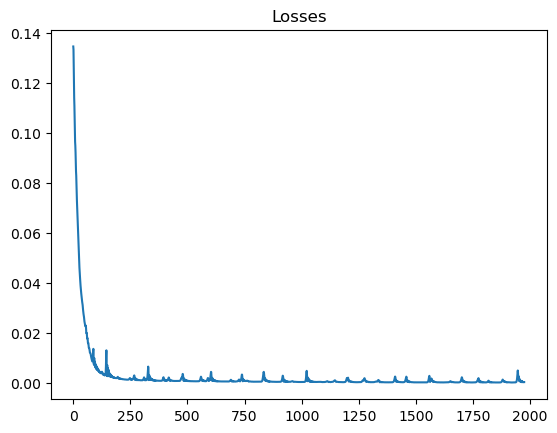

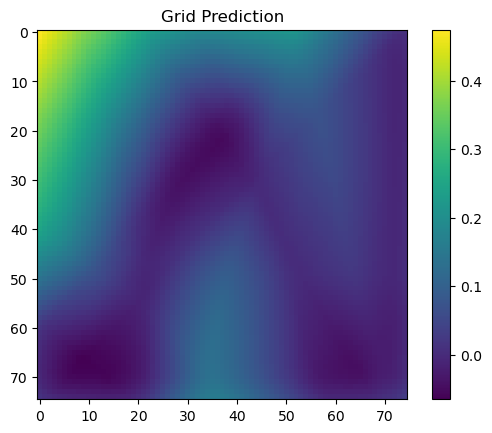

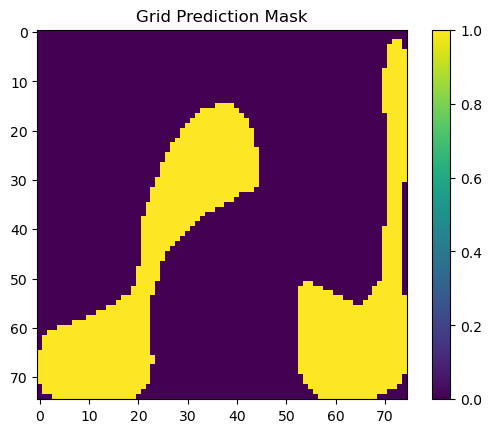

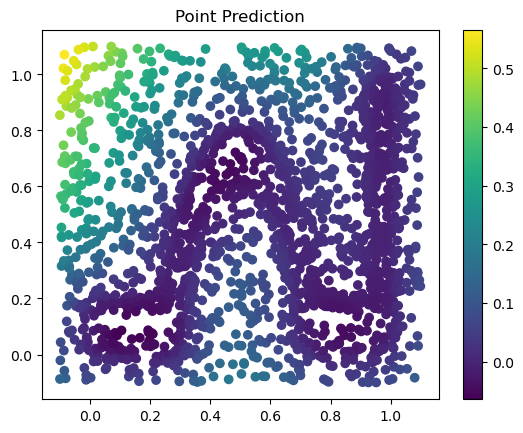

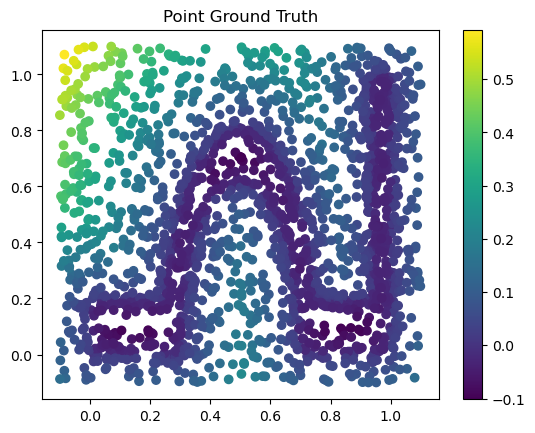

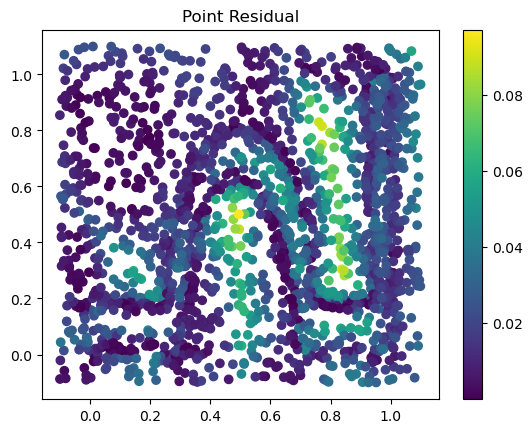

In [53]:
from torch_geometric.data import Batch
# Candidate GCN Layers that support edge attributes and bipartite graphs
# We would also love to have some form of residual here if possible
from automate import BipartiteResMRConv, LinearBlock
from torch_geometric.nn import (
    GATv2Conv, # Number of attention heads is likely important, lazy
    TransformerConv, # Number of attention heads likely important, lazy, can do weighted residual
    GINEConv, # No residual-like function
    GMMConv, # Guassion-Mixture Model (2016), lazy
    NNConv, # Provide your own NN as input, lazy
    CGConv, # Used for crystal graphs
    GENConv, # From follow-up to DeepGCNs - very general, and lazy
    GeneralConv # From Design Space for GNNs paper, lazy, can do attention w/ multiple heads
)

import os
import platform
if platform.system() == 'Linux' and 'microsoft' not in platform.release():
    os.environ['PYOPENGL_PLATFORM'] = 'egl'
import pyrender

import torch
import torch_geometric as tg
from pytorch_lightning import LightningModule
from hybridbrep import ImplicitDecoder

class HybridPredictor(LightningModule):
    def __init__(self):
        super().__init__()
        self.renderer = None

    def ensure_renderer(self):
        if self.renderer is None:
            self.renderer = pyrender.OffscreenRenderer(
                viewport_width=200,
                viewport_height=200,
                point_size=1.0
            )
        pass

    def destroy_renderer(self):
        if self.renderer is not None:
            self.renderer.delete()

    def forward(self, batch, face_coords, edge_coords=None):
        return self.model(batch, face_coords, edge_coords)

    def mesh_enc_dec(self, batch, n_samples, grid_bounds=(-.1,1.1)):
        face_codes = self.encode_faces(batch)
        edge_codes = self.encode_edges(batch)
        Vs, Fs = self.mesh_decode(face_codes, n_samples, edge_codes, grid_bounds)
        # TODO - label by originating part
        return Vs, Fs

    def mesh_decode(self, face_codes, n_samples=50, edge_codes=None, grid_bounds=(-.1,1.1)):
        decoded = self.grid_decode(face_codes, n_samples, edge_codes, grid_bounds)
        if edge_codes is None:
            face_preds = decoded
        else:
            face_preds, edge_preds = decoded
        Vs = None
        Fs = None
        # TODO - renumber by originating part if reasonable
        return Vs, Fs

    def grid_enc_dec(self, batch, n_samples=50, grid_bounds=(-.1,1.1)):
        face_codes = self.encode_faces(batch)
        edge_codes = self.encode_edges(batch)
        return self.grid_decode(face_codes, n_samples, edge_codes, grid_bounds)
    
    def grid_decode(self, face_codes, n_samples=50, edge_codes=None, grid_bounds=(-.1,1.1)):
        n_faces = face_codes.shape[0]
        face_u = torch.linspace(0, 1, n_samples, device=face_codes.device)
        face_uv = torch.stack([torch.cartesian_prod(face_u, face_u)]*n_faces)
        #face_batch = torch.arange(n_faces).repeat_interleave(3)
        face_preds = self.decode_faces(face_codes, face_uv)
        if edge_codes is not None:
            n_edges = edge_codes.shape[0]
            edge_grid = torch.linspace(0.0,1.0,n_samples,device=edge_codes.device).repeat(n_edges,1)
            edge_preds = self.decode_edges(edge_codes, edge_grid)
            return face_preds, edge_preds
        else:
            return face_preds
        
        

    def eval_common(self, batch, batch_idx):
        # Edge Targets and coordinates
        n_curves, n_c_samples, c_sample_dim = batch.curve_samples.shape
        c_xyz = batch.curve_samples[:,:,:3].reshape((-1,3))
        edge_coords = torch.linspace(0.,1.,n_c_samples,device=batch.faces.device).repeat(n_curves).reshape((n_curves,-1))

        # Face Targets
        n_surfs, n_s_samples, s_sample_dim = batch.surface_samples.shape
        s_xyz = batch.surface_samples[:,:,:3].reshape((-1,3))
        s_m = batch.surface_samples[:,:,s_sample_dim-1].flatten()
        face_coords = batch.surface_coords

        _, face_preds, _, edge_preds = self(batch, face_coords, edge_coords)

        face_preds_xyz = face_preds[:,:3]
        face_preds_m = face_preds[:,3]

        edge_loss = torch.nn.functional.mse_loss(edge_preds, c_xyz)
        face_loss_xyz = torch.nn.functional.mse_loss(face_preds_xyz, s_xyz)
        face_loss_mask = ((face_preds_m - s_m)**2).mean()#torch.nn.functional.mse_loss(face_preds_m, s_m)

        loss = edge_loss + face_loss_xyz + face_loss_mask

        return loss, edge_loss, face_loss_xyz, face_loss_mask

    def training_step(self, batch, batch_idx):
        loss, edge_loss, face_loss_xyz, face_loss_mask = self.eval_common(batch, batch_idx)
        self.log('edge_loss', edge_loss)
        self.log('face_loss_xyz', face_loss_xyz)
        self.log('face_loss_mask', face_loss_mask)
        self.log('loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=5e-4)

class GeneralConvEncDec(HybridPredictor):
    def __init__(self, emb_dim=128, dec_dim=128, dec_layers=4):
        super().__init__()
        #self.V_in = LinearBlock(3, emb_dim)
        #self.E_in = LinearBlock(17, emb_dim)
        #self.F_in = LinearBlock(20, emb_dim)
        self.edge_enc = GeneralConv(-1,emb_dim,-1, attention=True, heads=2)
        self.face_enc = GeneralConv(-1,emb_dim,-1, attention=True, heads=32)
        self.edge_dec = ImplicitDecoder(emb_dim+1, 3, dec_dim, dec_layers, use_tanh=False)
        self.face_dec = ImplicitDecoder(emb_dim+2, 4, dec_dim, dec_layers, use_tanh=False)
    
    def encode_edges(self, batch):
        #oh= batch.edges#torch.nn.functional.one_hot(torch.arange(len(batch.edges), device=batch.faces.device)).float()
        #oh[:,3:6] = torch.tanh(oh[:,3:6])
        edge_codes = self.edge_enc((batch.vertices,batch.edges),batch.vertex_to_edge,None,batch.vertex_to_edge_is_start)
        #edge_codes = torch.zeros_like(edge_codes)
        #edge_codes[:,:oh.shape[1]] = oh
        return edge_codes

    def encode_faces(self, batch, edge_codes=None):
        if edge_codes is None:
            edge_codes = self.encode_edges(batch)
        #oh = batch.faces#torch.nn.functional.one_hot(torch.arange(len(batch.faces),device=batch.faces.device)).float()
        face_codes = self.face_enc((edge_codes, batch.faces),batch.edge_to_face,None,batch.edge_to_face_flipped)
        #face_codes = torch.zeros_like(face_codes)
        #face_codes[:,:oh.shape[1]] = oh
        return face_codes

    def decode_faces(self, face_codes, face_coords):
        n_surfs, n_s_samples, _ = face_coords.shape
        s_uv = face_coords.reshape((-1,2))
        rep_face_codes = face_codes.repeat_interleave(n_s_samples,dim=0)
        face_dec_input = torch.cat([s_uv, rep_face_codes],dim=1)
        return self.face_dec(face_dec_input)

    def enc_dec(self, batch, face_coords, edge_coords=None):
        edge_codes = self.encode_edges(batch)
        face_codes = self.encode_faces(batch, edge_codes)
        face_preds = self.decode_faces(face_codes, face_coords)
        if edge_coords is None:
            return face_codes, face_preds
        edge_preds = self.decode_edges(edge_codes, edge_coords)
        return face_codes, face_preds, edge_codes, edge_preds

    # edge_coords: [n_edges x n_edge_samples]
    def decode_edges(self, edge_codes, edge_coords):
        n_edges, n_c_samples = edge_coords.shape
        c_t = edge_coords.reshape((-1,1))
        rep_face_codes = edge_codes.repeat_interleave(n_c_samples,dim=0)
        face_dec_input = torch.cat([c_t, rep_face_codes],dim=1)
        return self.edge_dec(face_dec_input)

    def forward(self, batch, face_coords, edge_coords=None):
        return self.enc_dec(batch, face_coords, edge_coords)

import pytorch_lightning as pl

part_path = '../../datasets/frame_guide/fg1.x_t'
#part_path = '../../caddata/frame_guide/fg1.x_t'

hp = HPart(part_path,n_samples=2000, normalize=True)
class FixedDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.data = hp.data
    def __getitem__(self, idx):
        return self.data
    def __len__(self):
        return 1


num_epochs = 2000
dl = tg.loader.DataLoader(FixedDataset(), batch_size=1)
model = GeneralConvEncDec(emb_dim=64, dec_dim=1024, dec_layers=4)
model = model.to('cuda')
dat = next(iter(dl))
dat = dat.to('cuda')

from tqdm import tqdm

losses=[]
optimizer = model.configure_optimizers()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    loss = model.training_step(dat, 0)
    loss.backward()
    losses.append(loss.detach().to('cpu').item())
    optimizer.step()


with torch.no_grad():

    #model.load_state_dict(sd)
    #print(model.eval_common(next(iter(dl)),0))
    #trainer = pl.Trainer(max_epochs=num_epochs,log_every_n_steps=1)
    #trainer.fit(model,dl)
    #print(model.eval_common(next(iter(dl)),0))

    #model = model.to('cpu')

    #batch = next(iter(dl))
    n_curves, n_c_samples, c_sample_dim = dat.curve_samples.shape
    #c_xyz = batch.curve_samples[:,:,:3].reshape((-1,3))
    edge_coords = torch.linspace(0.,1.,n_c_samples,device=dat.curve_samples.device).repeat(n_curves).reshape((n_curves,-1))

    # Face Targets
    #n_surfs, n_s_samples, s_sample_dim = batch.surface_samples.shape
    #s_xyz = batch.surface_samples[:,:,:3].reshape((-1,3))
    #s_m = batch.surface_samples[:,:,s_sample_dim-1].flatten()
    #face_coords = batch.surface_coords

    #fc,fp,ec,ep = model(batch, face_coords, edge_coords)
    grid_size = 75
    fp, ep = model.grid_enc_dec(dat,grid_size)
    fp = fp.to('cpu')
    ep = ep.to('cpu')

    _,fp_batch,_,ep_batch = model(dat, dat.surface_coords, edge_coords)
    fp_batch = fp_batch.to('cpu')
    ep_batch = ep_batch.to('cpu')
    del edge_coords
    #V = batch.curve_samples[:,:,:3].reshape((-1,3)).numpy()
    #plot = mp.plot(ep.detach().numpy(), return_plot=True, shading={'point_size':0.3})
    #plot.add_points(V, shading={'point_color':'green', 'point_size':0.3})
    #points = fp[:,:3]
    mask = fp[:,3].reshape((-1,grid_size,grid_size)).flip(dims=(2,)).numpy()
    mask_batch = fp_batch[:,-1].numpy().reshape((dat.surface_coords.shape[0],-1))
    uv_batch = dat.surface_coords.to('cpu').numpy()

    #m_points = points[mask <= 0]
    plt.plot(losses[25:])
    plt.title('Losses')
    
    # Point Cloud Plotting
    n_faces = dat.surface_samples.shape[0]

    plot = mp.plot(ep.numpy(),shading={'point_color':'green','point_size':0.1}, return_plot=True)
    fp_rand = fp.numpy()[np.random.choice(fp.shape[0], 30000,replace=False)]
    xyz = fp_rand[:,:3]
    m = fp_rand[:,3]
    fp_color = (m <= 0)
    plot.add_points(xyz,c=fp_color,shading={'point_size':0.1})
    #grid_plot = mp.plot(fp_xyz,c=fp_color,shading={'point_size':0.2},return_plot=True)
    #grid_plot.add_points(ep.numpy(), shading={'point_color':'green','point_size':0.3})

    #grid_face_points = fp.reshape((n_faces,-1,4))
    #grid_edge_points = fp.reshape((n_curves,-1))



    # Mask Plotting
    faces_to_plot = [11] # range(mask.shape[0])
    for f_idx in faces_to_plot:
        print(f'Face {f_idx}:')
        plt.figure()
        plt.imshow(mask[f_idx].T)
        plt.title('Grid Prediction')
        plt.colorbar()
        plt.figure()
        plt.imshow(mask[f_idx].T <= 0)
        plt.title('Grid Prediction Mask')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=mask_batch[f_idx])
        plt.title('Point Prediction')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=dat.surface_samples[f_idx,:,-1].to('cpu').numpy())
        plt.title('Point Ground Truth')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=np.abs((dat.surface_samples[f_idx,:,-1].to('cpu').numpy()-mask_batch[f_idx])))
        plt.title('Point Residual')
        plt.colorbar()

    del dat
    del model

    torch.cuda.empty_cache()
#plot.add_points(points.detach().numpy(), c=(mask.detach().numpy() <= 0), shading={'point_color':'blue', 'point_size':0.15})

In [ ]:
dat = next(iter(dl))
dat


In [45]:
data = next(iter(dl))
planes = data.faces[:,:5].argmax(dim=1) == 0
plane_bounds = data.surface_bounds[planes]
plane_params = data.faces[planes,5:-1]
plane_origins = plane_params[:,:3]
plane_normals = plane_params[:,3:6]
plane_ref_dirs = plane_params[:,9:12]
plane_y_dirs = plane_normals.cross(plane_ref_dirs,dim=1)
plane_origins_proj = (plane_normals.T*((plane_origins * plane_normals).sum(dim=1))).T
plane_origin_diffs = plane_origins - plane_origins_proj
plane_u_shifts = (plane_origin_diffs * plane_ref_dirs).sum(dim=1)
plane_v_shifts = (plane_origin_diffs * plane_y_dirs).sum(dim=1)
plane_bounds[:,:,0] = (plane_bounds[:,:,0].T + plane_u_shifts).T
plane_bounds[:,:,1] = (plane_bounds[:,:,1].T + plane_v_shifts).T
data.surface_bounds[planes] = plane_bounds
data.faces[planes,5:8] = plane_origins_proj

cylinders = data.faces[:,:5].argmax(dim=1) == 1
cylinder_bounds = data.surface_bounds[cylinders]
cylinder_params = data.faces[cylinders,5:-1]
cylinder_origins = cylinder_params[:,:3]
cylinder_axes = cylinder_params[:,6:9]
cylinder_origins_proj = cylinder_origins - (
    cylinder_axes.T * (cylinder_origins * cylinder_axes).sum(dim=1)).T
cylinder_v_shifts = ((cylinder_origins - cylinder_origins_proj)*cylinder_axes).sum(dim=1)
cylinder_bounds[:,:,1] = (cylinder_bounds[:,:,1].T + cylinder_v_shifts).T
data.surface_bounds[cylinders] = cylinder_bounds
data.faces[cylinders,5:8] = cylinder_origins_proj

lines = data.edges[:,:3].argmax(dim=1) == 0
line_params = data.edges[lines,3:-1]
line_origins = line_params[:,:3]
line_dirs = line_params[:,3:6]
line_origins_proj = line_origins - (
    line_dirs.T * (line_origins * line_dirs).sum(dim=1)).T
line_bounds = data.curve_bounds[lines]
line_t_shifts = ((line_origins - line_origins_proj)*line_dirs).sum(dim=1)
line_bounds = (line_bounds.T + line_t_shifts).T
data.curve_bounds[lines] = line_bounds
data.edges[lines,3:6] = line_origins_proj

In [49]:
circles = data.edges[:,1] == 1
data.edges[circles,3+12:]

tensor([[0.1347, 0.0000, 0.0000],
        [0.5907, 0.0000, 0.0000],
        [0.5907, 0.0000, 0.0000],
        [0.1347, 0.0000, 1.0000],
        [0.7772, 0.0000, 0.0000],
        [0.7772, 0.0000, 0.0000]])

In [ ]:
plane_u_shifts

In [ ]:
plane_v_shifts

In [ ]:
mp.plot(ep.numpy(),shading={'point_color':'green','point_size':0.1})

In [ ]:
dat = next(iter(dl))
dat
dat.edges.shape
diffs = torch.zeros((42,42))
for i in range(42):
    for j in range(42):
        diffs[i,j] = (dat.edges[i] - dat.edges[j]).abs().sum()
plt.imshow(np.log(diffs.numpy()))
plt.colorbar()
edge_matches = {tuple(sorted(x.tolist())) for x in (diffs == 0).nonzero() if x[0] != x[1]}
print(edge_matches)

In [ ]:
dat.faces[:,:5].argmax(dim=1)

In [ ]:
dat.faces[-3]

In [ ]:
dat.surface_bounds[-3]

In [ ]:
dat.curve_bounds[0]

In [ ]:
diffs = torch.zeros((16,16))
for i in range(16):
    for j in range(16):
        diffs[i,j] = (dat.faces[i] - dat.faces[j]).abs().sum()
plt.imshow(np.log(diffs.numpy()))
plt.colorbar()
face_matches = {tuple(sorted(x.tolist())) for x in (diffs == 0).nonzero() if x[0] != x[1]}
print(face_matches)

In [ ]:
surface_samples = dat.surface_samples[:,:,:3]
surface_masks = dat.surface_samples[:,:,-1]
xyz = surface_samples.reshape((-1,3)).numpy()
mp.plot(xyz, shading={'point_size':.1})

In [ ]:
dat.edges[1]

In [ ]:
part = HybridPart('../../caddata/frame_guide/fg1.x_t', 500, 5000, True)

In [ ]:
hp.data

In [ ]:
hp = HPart('../../caddata/frame_guide/fg1.x_t',n_samples=500, normalize=True)#'../../datasets/frame_guide/fg1.x_t', n_samples=500, normalize=True)
hpd = hp.data
gt_u = hpd.surface_coords[11][:,0].detach().numpy()
gt_v = hpd.surface_coords[11][:,1].detach().numpy()
gt_mask = hpd.surface_samples[11][:,-1].detach().numpy()

plt.scatter(gt_u,gt_v,c=gt_mask)
plt.colorbar()

In [ ]:
hpx = HybridPart('../../datasets/cubes/angled_cube.x_t',500,5000,False)
hps = HybridPart('../../datasets/cubes/angled_cube.step',500,5000,False)


In [ ]:
plt.imshow(mask[11].T <= 0.03)
plt.title('Grid Prediction')
plt.colorbar()

In [ ]:
plt.plot(np.arange(len(losses))[np.array(losses) < .01], np.array(losses)[np.array(losses) < .01])
plt.title('Losses')

In [ ]:
del fp_batch, ep_batch

In [ ]:
#fc,fp,ec,ep = model(batch, face_coords, edge_coords)

gp = model.grid_enc_dec(next(iter(dl)),50)
fp,ep = gp
V = batch.curve_samples[:,:,:3].reshape((-1,3)).numpy()
#plot = mp.plot(ep.detach().numpy(), return_plot=True, shading={'point_size':0.3})
#plot.add_points(V, shading={'point_color':'green', 'point_size':0.3})
points = fp[:,:3]
mask = fp[:,3]
m_points = points[mask <= 0]
plt.imshow((mask.reshape((-1,50,50)) <= 0)[11].detach().numpy())
#plot.add_points(points.detach().numpy(), c=(mask.detach().numpy() <= 0), shading={'point_color':'blue', 'point_size':0.15})

In [ ]:
fc,fp,ec,ep = model(batch, face_coords, edge_coords)

In [ ]:
# Current problems are _both_ not enough sample density and not enough
# predictor resolution
# Proposed Solutions:
# - sample density - preferentially sample near boundaries
# - prediction resolution - try a siren-net or similar

In [ ]:
batch.surface_samples

In [ ]:
pred_mask = fp.reshape((-1,1000,4))[11][:,-1].detach().numpy()
plt.scatter(gt_u,gt_v,c=pred_mask)
plt.colorbar()

In [ ]:
hp = HPart('../../caddata/frame_guide/fg1.x_t',n_samples=1000, normalize=True).data#'../../datasets/frame_guide/fg1.x_t', n_samples=500, normalize=True)

gt_u = hp.surface_coords[11][:,0].detach().numpy()
gt_v = hp.surface_coords[11][:,1].detach().numpy()
gt_mask = hp.surface_samples[11][:,-1].detach().numpy()

plt.scatter(gt_u,gt_v,c=gt_mask)
plt.colorbar()

In [ ]:
gt_mask.max()

In [ ]:
V = batch.surface_samples[11,:,:3].reshape((-1,3))
mask = batch.surface_samples[11,:,-1].flatten()
V_m = V[mask <= 0].detach().numpy()
mp.plot(V.detach().numpy(),c=(mask.detach().numpy()<=0),shading={'point_size':0.4})

In [ ]:
gt_u.shape

In [ ]:
plt.scatter(gt_u, gt_v,c=gt_mask)

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
gp = model.grid_enc_dec(next(iter(dl)),50)
fp,ep = gp
V = batch.curve_samples[:,:,:3].reshape((-1,3)).numpy()
plot = mp.plot(ep.detach().numpy(), return_plot=True, shading={'point_size':0.3})
plot.add_points(V, shading={'point_color':'green', 'point_size':0.3})
points = fp[:,:3]
mask = fp[:,3]
plot.add_points(points.detach().numpy(), c=(mask.detach().numpy() <= 0), shading={'point_color':'blue', 'point_size':0.15})

In [ ]:
plot = mp.plot(ep.detach().numpy(), return_plot=True)
plot.add_points(V, shading={'point_color':'green'})

In [ ]:
fp[:,:3].min()

In [ ]:
fp[:,:3].max()

In [ ]:
batch.surface_samples[:,:,:3].max()

In [ ]:
#gp = model.grid_enc_dec(next(iter(dl)),23)
#fp,ep = gp
fc,fp,ec,ep = model(batch, face_coords, edge_coords)

V = batch.curve_samples[:,:,:3].reshape((-1,3)).numpy()
V_f = batch.surface_samples[:,:,:3].reshape((-1,3)).numpy()
V_f = V_f[(batch.surface_samples[:,:,-1] <= 0).flatten().numpy()]
plot = mp.plot(ep.detach().numpy(), return_plot=True, shading={'point_size':0.3})
plot.add_points(V, shading={'point_color':'green', 'point_size':0.3})
plot.add_points(V_f, shading={'point_color':'blue', 'point_size':0.15})
#plot.add_points(fp[:,:3].detach().numpy(), shading={'point_color':'blue', 'point_size':0.15})


In [ ]:
batch.surface_samples[:,:,-1]

In [ ]:
# (d->h)*1, (d+h->h)*K, (d+h->o)*1

# ([dxh],[h]),  ([d+hxh],[h])*K, ([d+h x o], [o])

dim=1
hidden_dim=64
hidden_layers=4
out = 4

def lin_size(in_size, out_size):
    return in_size*out_size + out_size

def make_linear_layer(embedding, shape):
    (in_size, out_size) = shape
    weights = embedding[:in_size*out_size].reshape((in_size, out_size))
    biases = embedding[in_size*out_size,in_size*out_size+out_size]
    rest = embedding[in_size*out_size+out_size:]
    return (weights, biases, rest)

emb_size = (
    (dim*hidden_dim) + hidden_dim + # Input layer
    ( (dim+hidden_dim)*hidden_dim + hidden_dim)*(hidden_layers-1) + # Hidden Layers
    (dim+hidden_dim)*out + out # Output Layers
)




